In [2]:
from pathlib import Path
import pandas as pd

In [3]:
def strip_non_numeric(s):
    return ''.join(c for c in s if c.isdigit() or c in ['.', '-'])

def parse(line):


    metric_dict = {}
    # Split the line
    metrics = line.split(',')

    for metric in metrics:

        try:
            if 'tpr' in metric:
                metric_dict['tpr'] = float(strip_non_numeric(metric.rsplit()[-1]))
            if 'tnr' in metric:
                metric_dict['tnr'] = float(strip_non_numeric(metric.rsplit()[-1]))
            if 'loss' in metric:
                metric_dict['loss'] = float(strip_non_numeric(metric.rsplit()[-1]))
        except Exception as e:
            print(e)
            print('Error parsing metric: ', metric)
            raise e

    return metric_dict

def process_logfile(log_file_path: Path):

    # Read the log file
    with open(log_file_path, 'r') as file:
        lines = file.readlines()

    training_metrics = {}
    validation_metrics = {}


    trn = 0
    val = 0
    while lines:

        # Get the first line
        line = lines.pop(0)

        # Check if the line contains the training metrics
        if 'Training' in line:
            training_metrics[trn] = parse(','.join([lines.pop(0) for _ in range(3)]))
            trn+=1

        # Check if the line contains the validation metrics
        if 'Validation' in line:
            validation_metrics[val] = parse(','.join([lines.pop(0) for _ in range(2)]))
            val+=1


    return pd.DataFrame.from_dict(training_metrics, orient='index'), pd.DataFrame.from_dict(validation_metrics, orient='index')

log_file_paths = [log_file_path for log_file_path in Path('LUNA/arm2').rglob('log')]

fold_logs = {
    'fold1' : {'training': {},'validation': {}},
    'fold2' : {'training': {},'validation': {}},
    'fold3' : {'training': {},'validation': {}},
    'fold4' : {'training': {},'validation': {}},
    'fold5' : {'training': {},'validation': {}},
}

for fdx, log_file_path in enumerate(log_file_paths):
    print(log_file_path)

    fold = log_file_path.parts[-2]

    trn, val = process_logfile(log_file_path)
    fold_logs[fold]['training'] = trn
    fold_logs[fold]['validation'] = val

LUNA/arm2/fold2/log
LUNA/arm2/fold3/log
LUNA/arm2/fold4/log
LUNA/arm2/fold1/log
LUNA/arm2/fold5/log


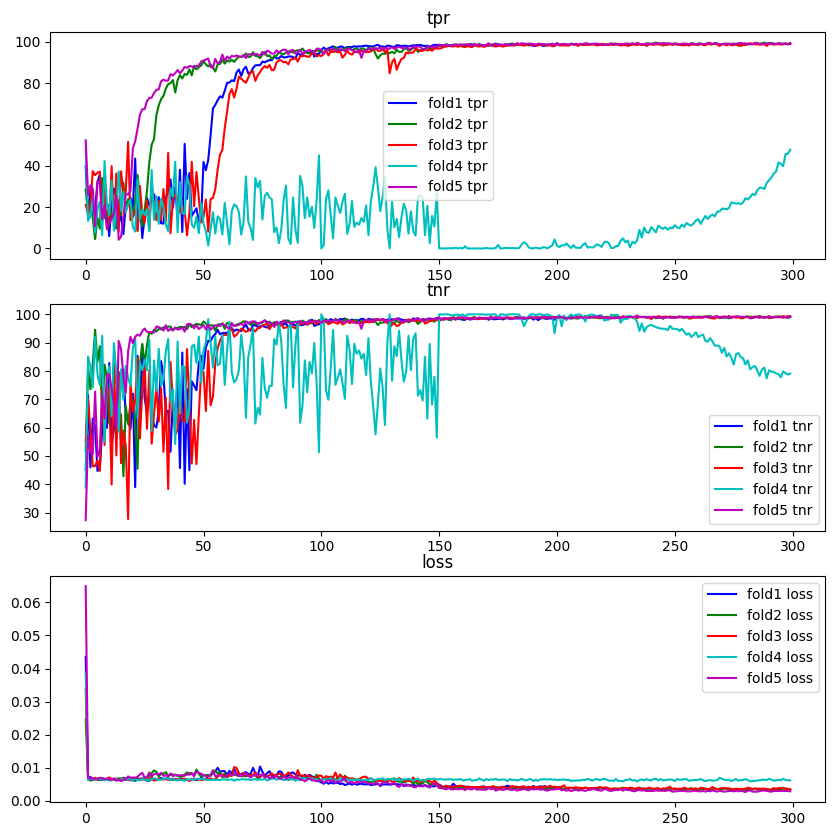

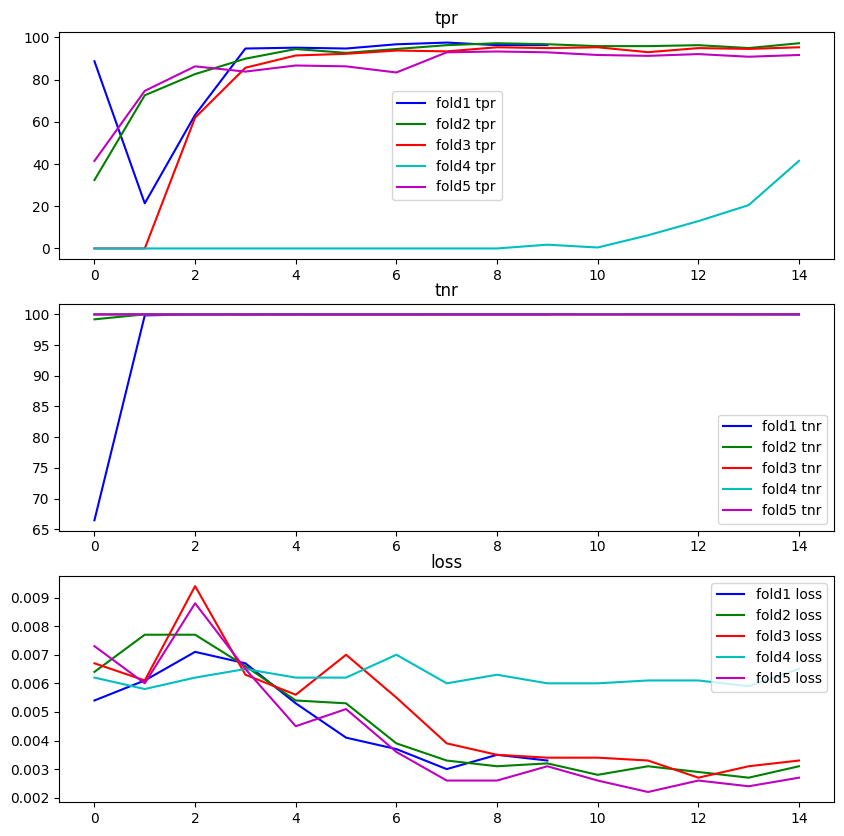

In [4]:
import matplotlib.pyplot as plt

def plot_training_data(metrics, dataset):


    fig, ax = plt.subplots(3, 1, figsize=(10, 10))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for fdx, fold in enumerate(metrics):
        data = metrics[fold][dataset]

        for idx, metric in enumerate(data.columns):
            ax[idx].plot(data[metric], label=f'{fold} {metric}', color=colors[fdx])
            ax[idx].set_title(metric)
            ax[idx].legend()

    plt.show()


plot_training_data(fold_logs, 'training')
plot_training_data(fold_logs, 'validation')